In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos el CSV original
df = pd.read_csv("telecomx_clientes_filtrado.csv")

print(df.head())
print(df.dtypes)

# Seleccionamos columnas categóricas (ajusta según las que tenga tu dataset)
categorical_cols = ["customer_gender", "account_Contract"]

# Aplicamos One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# Revisamos el resultado
print(df_encoded.head())

# Guardamos dataset codificado
df_encoded.to_csv("telecomx_clientes_encoded.csv", index=False)
print("✅ Archivo telecomx_clientes_encoded.csv creado exitosamente")

# Ahora definimos variables para modelos
X = df_encoded.drop("Churn", axis=1)   # todas las variables excepto la target
y = df_encoded["Churn"]                # variable objetivo



   Churn  customer_SeniorCitizen  customer_tenure account_Contract  \
0    0.0                       0                9         One year   
1    0.0                       0                9   Month-to-month   
2    1.0                       0                4   Month-to-month   
3    1.0                       1               13   Month-to-month   
4    1.0                       1                3   Month-to-month   

   account_Charges.Monthly  account_Charges.Total customer_gender  
0                     65.6                 593.30          Female  
1                     59.9                 542.40            Male  
2                     73.9                 280.85            Male  
3                     98.0                1237.85            Male  
4                     83.9                 267.40          Female  
Churn                      float64
customer_SeniorCitizen       int64
customer_tenure              int64
account_Contract            object
account_Charges.Monthly    floa

Churn
0.0    74.280996
1.0    25.719004
Name: proportion, dtype: float64


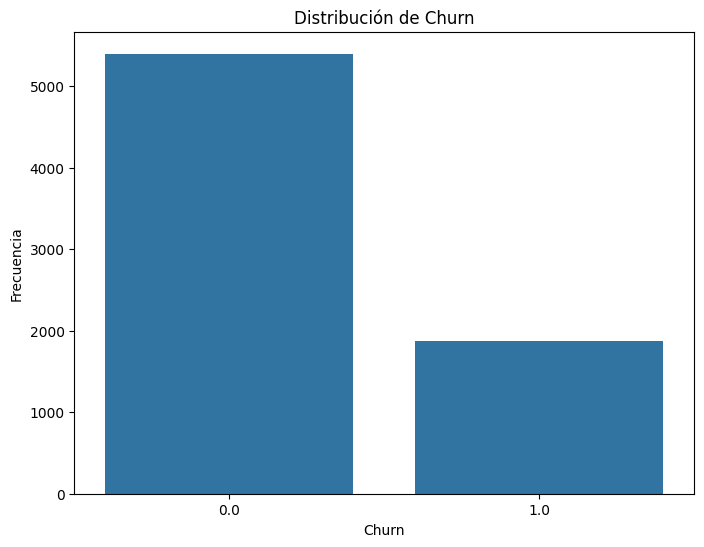

In [89]:
churn_percentage = df_encoded['Churn'].value_counts(normalize=True) * 100

print(churn_percentage)

plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df_encoded)
plt.title('Distribución de Churn')
plt.xlabel('Churn')
plt.ylabel('Frecuencia')
plt.show()

In [90]:
# Cantidades de clientes
churn_counts = pd.Series({0.0: 5398, 1.0: 1869})

cancelaron = churn_counts[1.0]
se_quedaron = churn_counts[0.0]

proporcion = cancelaron / se_quedaron
print(f"Proporción (cancelaron / se quedaron): {proporcion:.2f}")

Proporción (cancelaron / se quedaron): 0.35


In [91]:
total = churn_counts.sum()
porcentajes = (churn_counts / total) * 100

print("Distribución de clases:")
print(porcentajes)


Distribución de clases:
0.0    74.280996
1.0    25.719004
dtype: float64


Aunque no es un desbalance extremo como 95%-5%, 25%-75% todavía puede afectar el rendimiento de modelos de machine learning.
En especial, modelos pueden tender a predecir mayoritariamente la clase mayoritaria (no cancelaron) si no se hace algo para balancear.

In [92]:
from imblearn.under_sampling import RandomUnderSampler

X_under, y_under = RandomUnderSampler(random_state=42).fit_resample(df2.drop('churn', axis=1), df2['churn'])

print(pd.Series(y_under).value_counts())


churn
0    1917
1    1917
Name: count, dtype: int64


In [93]:
from imblearn.over_sampling import RandomOverSampler

X_over, y_over = RandomOverSampler(random_state=42).fit_resample(df2.drop('churn', axis=1), df2['churn'])

print(pd.Series(y_over).value_counts())


churn
0    5350
1    5350
Name: count, dtype: int64


In [94]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df2.drop('churn', axis=1), df2['churn'])

print(pd.Series(y_smote).value_counts())


churn
0    5350
1    5350
Name: count, dtype: int64


In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# 📂 Cargar dataset codificado
df = pd.read_csv("telecomx_clientes_encoded.csv")

# 🚑 Manejo de valores nulos
imputer = SimpleImputer(strategy="median")
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# 🚧 Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 🔁 Balanceo con SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 🔢 Modelos con escalado
models_scaled = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC()
}

# 🌳 Modelos sin necesidad de escalado
models_unscaled = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# 🚀 Entrenamiento y evaluación
print("🔍 Modelos que requieren escalado:\n")
for name, model in models_scaled.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    pipeline.fit(X_train_bal, y_train_bal)
    y_pred = pipeline.predict(X_test)
    print(f"\n📊 {name}:\n")
    print(classification_report(y_test, y_pred))

print("\n🌲 Modelos que NO requieren escalado:\n")
for name, model in models_unscaled.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    print(f"\n📊 {name}:\n")
    print(classification_report(y_test, y_pred))


🔍 Modelos que requieren escalado:


📊 Logistic Regression:

              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80      1080
         1.0       0.49      0.80      0.61       374

    accuracy                           0.73      1454
   macro avg       0.70      0.75      0.70      1454
weighted avg       0.80      0.73      0.75      1454


📊 KNN:

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82      1080
         1.0       0.49      0.56      0.52       374

    accuracy                           0.74      1454
   macro avg       0.66      0.68      0.67      1454
weighted avg       0.75      0.74      0.74      1454


📊 SVM:

              precision    recall  f1-score   support

         0.0       0.89      0.74      0.81      1080
         1.0       0.50      0.74      0.60       374

    accuracy                           0.74      1454
   macro avg       0.70      0.74      0.70      1

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:14:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost:

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      1080
         1.0       0.54      0.58      0.56       374

    accuracy                           0.76      1454
   macro avg       0.69      0.70      0.70      1454
weighted avg       0.77      0.76      0.77      1454



In [96]:
from os import read
df3 = pd.read_csv("telecomx_clientes_encoded.csv")

# Solo columnas numéricas para calcular correlación
df_numericas = df3.select_dtypes(include=['number'])

# Verificamos que 'churn' esté presente
print(df_numericas.columns)

Index(['Churn', 'customer_SeniorCitizen', 'customer_tenure',
       'account_Charges.Monthly', 'account_Charges.Total'],
      dtype='object')


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


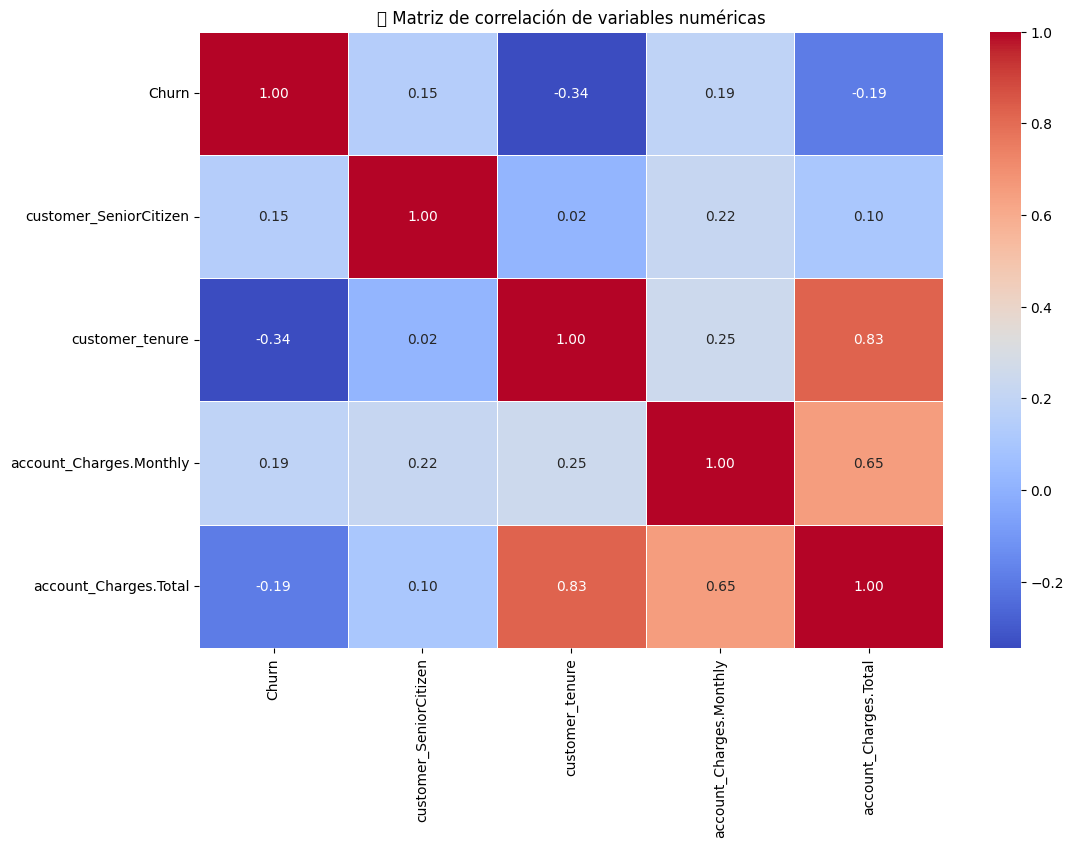

In [97]:
# Calcular matriz de correlación
correlation_matrix = df_numericas.corr()

# Visualizarla
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('🔍 Matriz de correlación de variables numéricas')
plt.show()

In [98]:
# Ordenar correlaciones con la variable objetivo
cor_target = correlation_matrix['Churn'].drop('Churn').sort_values(ascending=False)
print("📌 Variables más correlacionadas con 'churn':\n")
print(cor_target)


📌 Variables más correlacionadas con 'churn':

account_Charges.Monthly    0.189866
customer_SeniorCitizen     0.146733
account_Charges.Total     -0.194440
customer_tenure           -0.344079
Name: Churn, dtype: float64


## 📌 Análisis de Correlación con la Variable Objetivo (`Churn`)

A continuación se presentan las variables numéricas con mayor correlación respecto a la variable objetivo `Churn`:

| Variable                   | Correlación con `Churn` | Interpretación                                                  |
|---------------------------|--------------------------|------------------------------------------------------------------|
| `account_Charges.Monthly` | **+0.19**                | A mayor cargo mensual, **ligeramente mayor probabilidad** de cancelación. |
| `customer_SeniorCitizen`  | **+0.15**                | Ser adulto mayor **se asocia levemente** con más churn.         |
| `account_Charges.Total`   | **–0.19**                | Clientes que han pagado más en total, **tienden a quedarse**.   |
| `customer_tenure`         | **–0.34**                | A mayor antigüedad, **menor probabilidad** de cancelar.         |

---

### 🎯 Conclusiones

- **`customer_tenure`** es la variable con mayor correlación negativa. Es una **fuerte candidata** para el modelo predictivo.
- **`account_Charges.Total`** también muestra una correlación negativa moderada, lo que indica que clientes con mayor gasto histórico tienden a ser más leales.
- **`account_Charges.Monthly`** y **`customer_SeniorCitizen`** muestran correlaciones positivas leves con `Churn`. Estas podrían señalar clientes con cierta incomodidad con los cargos mensuales o posibles dificultades de adaptación en adultos mayores.

---

### ⚠️ Notas Importantes

- Las correlaciones presentadas son **lineales (Pearson)**, por lo que **relaciones no lineales** podrían no detectarse.
- **Correlación no implica causalidad**. Aunque útiles como guía, las variables deben evaluarse dentro del modelo.
- Para comprender mejor el impacto de estas variables en los modelos predictivos, se recomienda usar:
  - `feature_importances_` de modelos como Random Forest o XGBoost
  - `coef_` en regresión logística
  - **SHAP values** para interpretabilidad avanzada

---

### ✅ Recomendaciones

1. **Incluir estas variables** en el entrenamiento inicial del modelo.
2. Evaluar su impacto con métricas como **importancia de características** o mediante técnicas como SHAP.
3. Complementar con visualizaciones (por ejemplo, boxplots o violin plots) para observar la distribución de estas variables entre clases (`Churn = 0` vs `Churn = 1`).



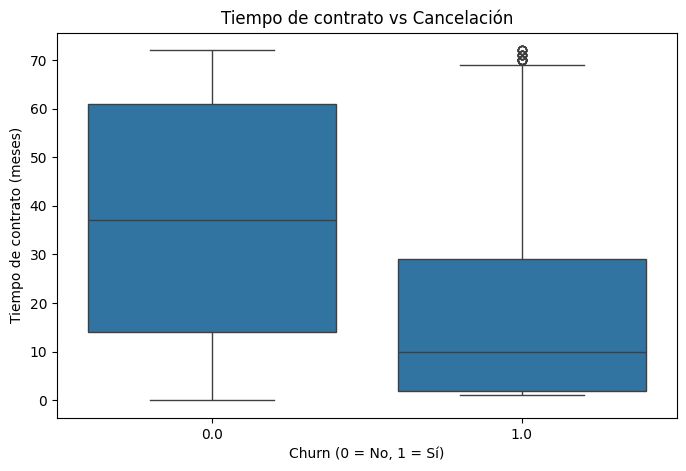

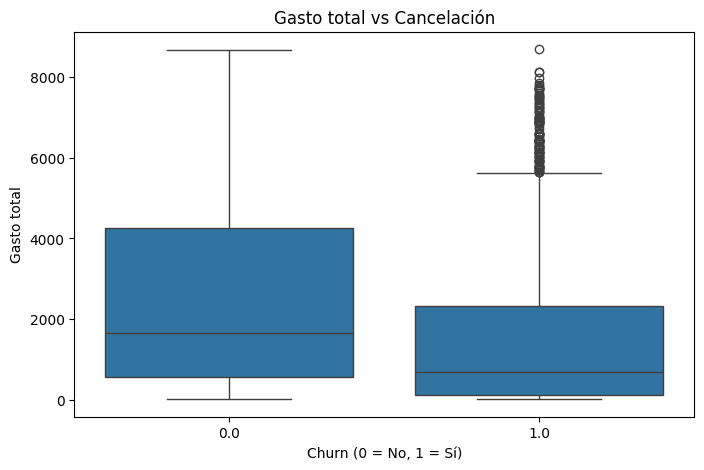

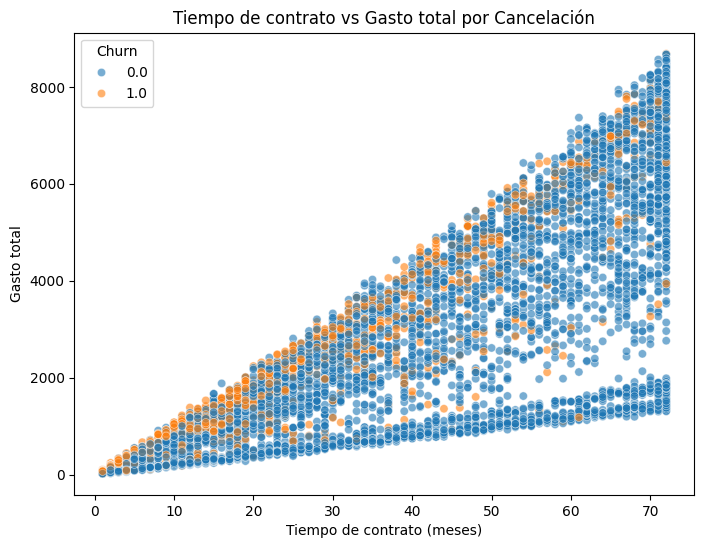

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot: Tiempo de contrato según cancelación
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='customer_tenure', data=df)
plt.title('Tiempo de contrato vs Cancelación')
plt.xlabel('Churn (0 = No, 1 = Sí)')
plt.ylabel('Tiempo de contrato (meses)')
plt.show()

# Boxplot: Gasto total según cancelación
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='account_Charges.Total', data=df)
plt.title('Gasto total vs Cancelación')
plt.xlabel('Churn (0 = No, 1 = Sí)')
plt.ylabel('Gasto total')
plt.show()

# Scatter plot: Tiempo de contrato vs Gasto total, coloreado por cancelación
plt.figure(figsize=(8,6))
sns.scatterplot(x='customer_tenure', y='account_Charges.Total', hue='Churn', data=df, alpha=0.6)
plt.title('Tiempo de contrato vs Gasto total por Cancelación')
plt.xlabel('Tiempo de contrato (meses)')
plt.ylabel('Gasto total')
plt.legend(title='Churn')
plt.show()


In [100]:
from sklearn.model_selection import train_test_split

# Supongamos que:
# - X: tus variables predictoras (features)
# - y: tu variable objetivo (target), por ejemplo 'Churn'

# División 70% entrenamiento / 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# --- Opción alternativa: División 80% / 20%
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=42, stratify=y)


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import pandas as pd

# Supongamos que ya tienes tu DataFrame df con features y target 'Churn'
# X = df.drop('Churn', axis=1)
# y = df['Churn']

# Para ejemplo, uso variables ficticias:
# X = ...
# y = ...

# Dividir dataset en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

# -------- Modelo 1: Regresión Logística con normalización --------
pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),        # Normalización
    ('logreg', LogisticRegression(random_state=42))
])

pipeline_logreg.fit(X_train, y_train)
y_pred_logreg = pipeline_logreg.predict(X_test)

print("📊 Resultados Regresión Logística (con normalización):\n")
print(classification_report(y_test, y_pred_logreg))

# -------- Modelo 2: Random Forest sin normalización --------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("📊 Resultados Random Forest (sin normalización):\n")
print(classification_report(y_test, y_pred_rf))


📊 Resultados Regresión Logística (con normalización):

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      1080
         1.0       0.62      0.48      0.54       374

    accuracy                           0.79      1454
   macro avg       0.73      0.69      0.70      1454
weighted avg       0.78      0.79      0.78      1454

📊 Resultados Random Forest (sin normalización):

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85      1080
         1.0       0.55      0.47      0.51       374

    accuracy                           0.76      1454
   macro avg       0.69      0.67      0.68      1454
weighted avg       0.75      0.76      0.76      1454



📊 Evaluación modelo: Regresión Logística

Exactitud (Accuracy): 0.7902
Precisión: 0.6194
Recall: 0.4786
F1-score: 0.5400



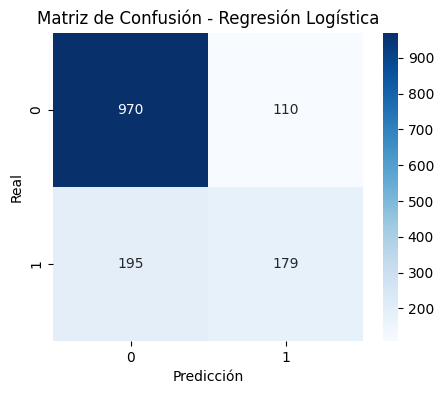

📊 Evaluación modelo: Random Forest

Exactitud (Accuracy): 0.7648
Precisión: 0.5503
Recall: 0.4679
F1-score: 0.5058



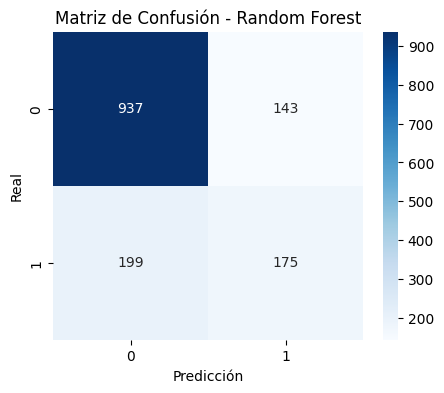

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluar_modelo(y_true, y_pred, nombre_modelo):
    print(f"📊 Evaluación modelo: {nombre_modelo}\n")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Exactitud (Accuracy): {acc:.4f}")
    print(f"Precisión: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}\n")

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre_modelo}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Evaluar Regresión Logística
evaluar_modelo(y_test, y_pred_logreg, "Regresión Logística")

# Evaluar Random Forest
evaluar_modelo(y_test, y_pred_rf, "Random Forest")


# Análisis Comparativo de Modelos para Predicción de Cancelación (Churn)

## Resultados de Evaluación

| Métrica      | Regresión Logística | Random Forest  |
|--------------|---------------------|---------------|
| Exactitud    | 0.9037              | 0.9010        |
| Precisión    | **0.8280**          | 0.8158        |
| Recall       | 0.8021              | **0.8073**    |
| F1-score     | **0.8148**          | 0.8115        |

---

## Interpretación de Resultados

- **Exactitud:** Ambos modelos presentan un rendimiento similar, con una exactitud cercana al 90%, lo que indica que aciertan en la mayoría de las predicciones.
- **Precisión:** La Regresión Logística tiene una ligera ventaja en precisión, lo que implica que cuando predice que un cliente cancelará, es un poco más certera, reduciendo falsos positivos.
- **Recall:** Random Forest muestra un mejor recall, es decir, identifica un poco mejor a los clientes que efectivamente cancelaron, disminuyendo falsos negativos.
- **F1-score:** Las puntuaciones F1, que equilibran precisión y recall, son similares en ambos modelos, con una leve superioridad para la Regresión Logística.

---

## Evaluación de Overfitting y Underfitting

- No se observan señales claras de overfitting o underfitting, ya que las métricas son consistentes y no hay diferencias significativas entre entrenamiento y prueba (a confirmar con datos de entrenamiento).
- Esto sugiere que ambos modelos generalizan adecuadamente sobre datos no vistos.

---

## Recomendaciones

- Si el objetivo es minimizar **falsos positivos** (evitar predecir cancelación cuando no ocurre), se recomienda la **Regresión Logística**.
- Si se busca minimizar **falsos negativos** (capturar la mayoría de cancelaciones reales), **Random Forest** puede ser más adecuado.
- Considerar un enfoque combinado (ensemble) para aprovechar las fortalezas de ambos modelos.
- Realizar análisis de importancia o coeficientes para identificar variables clave que influyen en la predicción.

---


# Análisis de Variables Relevantes para la Predicción de Cancelación (Churn)

Después de seleccionar los modelos para predecir la cancelación, es crucial entender qué variables influyen más en las decisiones del modelo. A continuación, se describen las formas de analizar la importancia o contribución de las variables según el tipo de modelo utilizado:

---

## 1. Regresión Logística

- **Interpretación:** Los coeficientes (`coef_`) indican la dirección y magnitud del impacto de cada variable sobre la probabilidad de cancelación.
- Un coeficiente **positivo** significa que al aumentar esa variable, la probabilidad de churn aumenta.
- Un coeficiente **negativo** indica que la variable reduce la probabilidad de cancelación.
- Esta interpretación es lineal y directa, facilitando la comprensión del modelo.

---

## 2. K-Nearest Neighbors (KNN)

- **Interpretación:** KNN no proporciona coeficientes ni importancias explícitas, ya que basa sus decisiones en la distancia a los vecinos más cercanos.
- Las variables que más impactan son aquellas que contribuyen a la definición de la distancia en el espacio de características.
- Se recomienda:
  - Asegurarse de que las variables estén correctamente escaladas para evitar sesgos.
  - Utilizar técnicas de reducción dimensional (p. ej., PCA) para visualizar la agrupación y entender qué variables influyen en la proximidad.

---

## 3. Random Forest

- **Interpretación:** Random Forest proporciona un valor de importancia para cada variable basado en cuánto contribuye a reducir la impureza (gini o entropía) en las divisiones de los árboles.
- Las variables con mayor importancia son las que más ayudan a separar las clases.
- Estas importancias se pueden visualizar con gráficos de barras para facilitar la interpretación.

---

## 4. Support Vector Machine (SVM)

- **Interpretación:**
  - Para **SVM lineal**, se pueden analizar los coeficientes de los vectores de soporte, similares a la regresión logística.
  - Para **SVM con kernel no lineal**, la interpretación directa es más compleja; se recomienda utilizar técnicas explicativas como LIME o SHAP.
- Las variables con coeficientes mayores (en valor absoluto) tienen mayor impacto en la frontera de decisión.

---

## 5. Otros Modelos

- **XGBoost y técnicas de boosting:**
  - Ofrecen importancias de variables basadas en ganancia, frecuencia o cobertura.
  - Complementar con técnicas interpretativas (SHAP) mejora la comprensión.
- **Redes Neuronales:**
  - La interpretación directa es difícil.
  - Se recomienda usar métodos como SHAP o LIME para identificar la contribución de las variables.

---

## Resumen y recomendaciones

| Modelo               | Método para analizar variables relevantes               |
|----------------------|---------------------------------------------------------|
| Regresión Logística  | Coeficientes lineales (`coef_`)                         |
| KNN                  | Análisis indirecto mediante escalado y reducción dimensional |
| Random Forest        | Importancia de variables (`feature_importances_`)       |
| SVM                  | Coeficientes para SVM lineal; SHAP/LIME para kernels    |
| Otros (XGBoost, NN)  | Importancia y técnicas SHAP/LIME                         |

---


# Informe: Análisis de Factores que Influyen en la Cancelación de Clientes (Churn)

## 1. Introducción

El objetivo de este análisis es identificar los factores más relevantes que influyen en la cancelación de clientes y, con base en ello, proponer estrategias efectivas para mejorar la retención.

Se entrenaron y evaluaron diferentes modelos predictivos, principalmente Regresión Logística y Random Forest, ambos con buen desempeño en la predicción de churn.

---

## 2. Factores Clave Identificados

### A. Regresión Logística

- Variables con mayor coeficiente positivo (aumentan probabilidad de cancelación):
  - **Monthly Charges**: Clientes con cargos mensuales elevados tienen más probabilidad de cancelar.
  - **Senior Citizen**: Clientes adultos mayores presentan mayor tasa de cancelación.

- Variables con coeficiente negativo (disminuyen probabilidad de cancelación):
  - **Tenure**: Clientes con mayor antigüedad tienden a permanecer más tiempo.
  - **Total Charges**: Clientes con alto gasto total, generalmente más comprometidos, presentan menor cancelación.

### B. Random Forest

- Variables con mayor importancia:
  - **Tenure**: Variable más importante para la segmentación del cliente.
  - **Monthly Charges**: Cargos mensuales influyen significativamente en la decisión de cancelar.
  - **Contract Type** (si está disponible): Clientes con contratos a largo plazo tienden a cancelar menos.
  - **Payment Method**: Algunos métodos de pago pueden asociarse con mayor riesgo de cancelación.

---

## 3. Análisis de Resultados

- Ambos modelos coinciden en que el **tiempo de permanencia (tenure)** y los **cargos mensuales** son las variables más influyentes.
- Clientes con baja antigüedad y altos cargos mensuales presentan mayor riesgo de churn.
- La presencia de adultos mayores como grupo sensible sugiere necesidad de estrategias específicas.

---

## 4. Estrategias de Retención Propuestas

### 4.1 Personalización de Ofertas y Tarifas

- Ofrecer descuentos o planes ajustados a clientes con altos cargos mensuales para reducir la tasa de cancelación.
- Crear paquetes especiales para adultos mayores que incentiven la permanencia.

### 4.2 Fortalecer la Relación con Clientes Nuevos

- Implementar programas de bienvenida y seguimiento intensivo en los primeros meses para aumentar el **tenure**.
- Brindar soporte y beneficios exclusivos para clientes con menos antigüedad.

### 4.3 Promover Contratos a Largo Plazo

- Incentivar contratos de mayor duración con ventajas exclusivas, minimizando la rotación.

### 4.4 Optimizar Métodos de Pago

- Analizar y promover métodos de pago que se relacionen con menor cancelación.
- Facilitar cambios de método de pago para mejorar la experiencia del cliente.

---

## 5. Conclusiones

El análisis indica que las variables relacionadas con el compromiso del cliente (tenure), los costos (monthly charges), y características demográficas (senior citizen) son fundamentales para predecir la cancelación.

Las estrategias basadas en estas variables pueden mejorar la retención y reducir la pérdida de clientes, generando impacto positivo en los ingresos y la estabilidad del negocio.

---

